# Bee Colony Loss & Health Throughout America
## Where are bees dying in America, and what is the cause of their deaths?

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import shapely
import fiona

Set default figuresize and font value

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)

font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 13}
matplotlib.rc('font', **font)

Column name replacement function

In [3]:
def replacement_columns(df, this, with_this):
    df.columns = [x.replace(this, with_this) for x in df.columns]
    return df.columns

### Reading the Data

In [4]:
loss_data = pd.read_excel("colony_loss.xlsx")
loss_data.iloc[98:108]

,Year,Season,State,Total Annual Loss,Beekeepers,Beekeepers Exclusive to State,Colonies,Colonies Exclusive to State
98,2015/16,Annual,Iowa,0.588,48,0.958,1256,0.640
99,2015/16,Annual,Utah,0.594,38,0.868,15873,0.028
100,2015/16,Annual,Delaware,0.602,21,0.762,25674,0.006
101,2015/16,Annual,Mississippi,0.713,12,0.667,22399,0.003
102,2015/16,Annual,Puerto Rico,NaN,1,1.000,1,1.000
103,2015/16,Annual,Alaska,NaN,2,1.000,7,1.000
104,2014/15,Annual,Hawaii,0.139,28,1.000,12093,1.000
105,2014/15,Annual,Oregon,0.252,142,0.944,44306,0.293
106,2014/15,Annual,South Carolina,0.262,71,0.887,2853,0.203
107,2014/15,Annual,Nevada,0.267,7,0.714,1853,0.019


### Cleaning the Data & Column Issues

Replace \xa0 with nothing.
Replace space with nothing.
Change the "State" column name to match the GeoJson, "NAME".
Remove all rows with a NaN value, e.g. Puerto Rico.

In [5]:
replacement_columns(loss_data, '\xa0', '')
replacement_columns(loss_data, ' ', '') 
replacement_columns(loss_data, 'State', 'NAME')
loss_data.dropna(how='any',axis='index', inplace=True)

loss_data.sample(5)

,Year,Season,NAME,TotalAnnualLoss,Beekeepers,BeekeepersExclusivetoNAME,Colonies,ColoniesExclusivetoNAME
34,2016/17,Annual,Kansas,0.477,16,0.938,23181,0.009
291,2011/12,Annual,Kentucky,0.369,28,0.964,869,0.972
214,2012/13,Annual,Vermont,0.299,39,0.897,4189,0.450
15,2016/17,Annual,South Dakota,0.322,12,0.500,29626,0.004
346,2010/11,Annual,South Dakota,0.448,7,0.857,2802,0.035


### Removing Unnecessary Data

Removed all inter-state information, as its extent is undefined
Removed the 'index' column to assist in later code

In [6]:
loss_data = loss_data.set_index("NAME")
loss_data = loss_data.drop(['MultiStateOperation'], axis=0) 
loss_data = loss_data.drop(['BeekeepersExclusivetoNAME', 'ColoniesExclusivetoNAME'], axis=1)

In [7]:
loss_data.sample(5)

,Year,Season,TotalAnnualLoss,Beekeepers,Colonies
NAME,,,,,
Vermont,2015/16,Annual,0.155,48,2374
North Carolina,2012/13,Annual,0.468,275,5812
California,2011/12,Annual,0.284,175,163019
Montana,2011/12,Annual,0.188,15,22359
North Carolina,2014/15,Annual,0.416,254,2700


Taking each value for Beekeeepers, Colonies and TotalAnnualLoss over the 7 year period, and averaging them out. They will be combined into a single row of data later, aside from loss_annual_by_date, while will be used to do a year-by-year comparison.

In [8]:
loss_beekeepers = loss_data.groupby(["NAME"]).Beekeepers.mean().round(decimals=3)
loss_colonies = loss_data.groupby(["NAME"]).Colonies.mean().round(decimals=3)
loss_annual_loss = loss_data.groupby(["NAME"]).TotalAnnualLoss.mean().round(decimals=3)
loss_annual_by_date = loss_data.groupby(["Year"]).TotalAnnualLoss.mean().round(decimals=3)

### Bar Graph Set-Up

In [9]:
bar_setup = pd.merge(loss_data, loss_annual_by_date, how='outer', on='Year')
bar_setup = bar_setup.drop(['Season', 'TotalAnnualLoss_x', 'Beekeepers', 'Colonies'], axis=1)
bar_setup.drop_duplicates(subset = 'TotalAnnualLoss_y', keep = 'first', inplace = True)
replacement_columns(bar_setup, 'TotalAnnualLoss_y', 'TotalAnnualLoss')
bar_setup.sample(5)

,Year,TotalAnnualLoss
149,2013/14,0.404
100,2014/15,0.447
0,2016/17,0.417
199,2012/13,0.439
50,2015/16,0.424


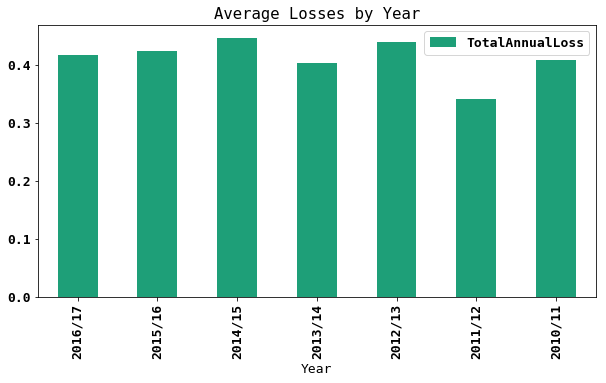

In [10]:
bar_setup[['Year', 'TotalAnnualLoss']].plot(x = 'Year', y = 'TotalAnnualLoss', 
                                            color = (0.117, 0.623, 0.470),
                                            kind='bar', title='Average Losses by Year');

Histogram gives an idea of the general percentage distribution of loss among the separate states.

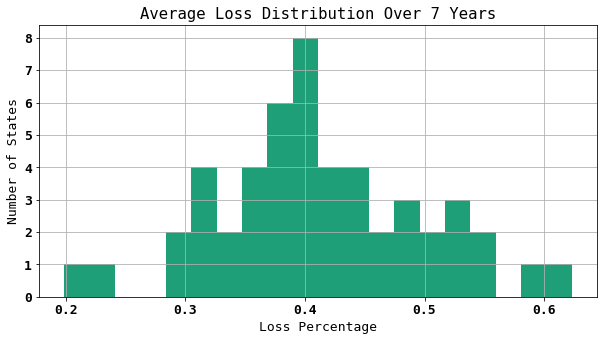

In [31]:
loss_annual_loss.hist(color = (0.117, 0.623, 0.470), bins=20);
plt.title("Average Loss Distribution Over 7 Years");
plt.xlabel("Loss Percentage");
plt.ylabel("Number of States");

### Plotting the Data

In [12]:
country = gpd.read_file("gz_2010_us_040_00_5m.json")
country.sample(10)

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
12,0400000US16,16,Idaho,,82643.117,"POLYGON ((-111.044156 43.020052, -111.044129 4..."
36,0400000US40,40,Oklahoma,,68594.921,"POLYGON ((-96.94461099999999 33.949217, -96.95..."
7,0400000US10,10,Delaware,,1948.543,"(POLYGON ((-75.564927 39.583248, -75.576271000..."
9,0400000US12,12,Florida,,53624.759,"(POLYGON ((-82.821585 27.964443, -82.829801 27..."
27,0400000US31,31,Nebraska,,76824.171,"POLYGON ((-104.053249 41.001406, -104.053158 4..."
41,0400000US46,46,South Dakota,,75811.000,"POLYGON ((-104.054487 44.180381, -104.055389 4..."
17,0400000US21,21,Kentucky,,39486.338,"(POLYGON ((-89.485106 36.497692, -89.492537 36..."
50,0400000US56,56,Wyoming,,97093.141,"POLYGON ((-110.048476 40.997555, -110.121639 4..."
48,0400000US54,54,West Virginia,,24038.210,"POLYGON ((-80.075947 39.72135, -79.91617100000..."
26,0400000US30,30,Montana,,145545.801,"POLYGON ((-105.038405 45.000345, -105.076607 4..."


### Removing Unnecessary Data & Merging Data

LSAD is an empty column that came with the GeoJson, and there isn't any need to work with census areas.

In [13]:
country = country.drop(['LSAD', 'CENSUSAREA'], axis=1)
country_loss = pd.merge(country, loss_annual_loss, how='outer', on='NAME')
country_loss = pd.merge(country_loss, loss_beekeepers, how='outer', on='NAME')
country_loss = pd.merge(country_loss, loss_colonies, how='outer', on='NAME')

Removed Alaska and Puerto Rico due to their NaN values under Total Annual Loss.
Also removed both of them and Hawaii as their ecology/ecosystem is different to the USA mainland.

In [14]:
c48 = country_loss[country_loss['NAME'].isin(['Alaska','Hawaii', 'Puerto Rico']) == False] # Bye, bye, Puerto Rico!
c48 = c48.set_index("GEO_ID")
c48.sample(5)

,STATE,NAME,geometry,TotalAnnualLoss,Beekeepers,Colonies
GEO_ID,,,,,,
0400000US55,55,Wisconsin,"(POLYGON ((-90.403306 47.026693, -90.403321000...",0.412,104.571,29836.857
0400000US56,56,Wyoming,"POLYGON ((-110.048476 40.997555, -110.121639 4...",0.321,15.600,18679.200
0400000US38,38,North Dakota,"POLYGON ((-98.72437499999999 45.938686, -98.90...",0.361,22.286,184978.714
0400000US16,16,Idaho,"POLYGON ((-111.044156 43.020052, -111.044129 4...",0.289,31.857,76720.286
0400000US35,35,New Mexico,"POLYGON ((-105.998003 32.002328, -106.099756 3...",0.395,14.714,426.429


### Finding Centroids for Geographic Plotting

In [15]:
def state_centroid(row):
    return row.geometry.centroid

c48["centroid"] = c48.apply(state_centroid, axis=1)

Annotation on one line to make room for graph. Yellow = Highest losses. Dark Blue = Lowest losses.

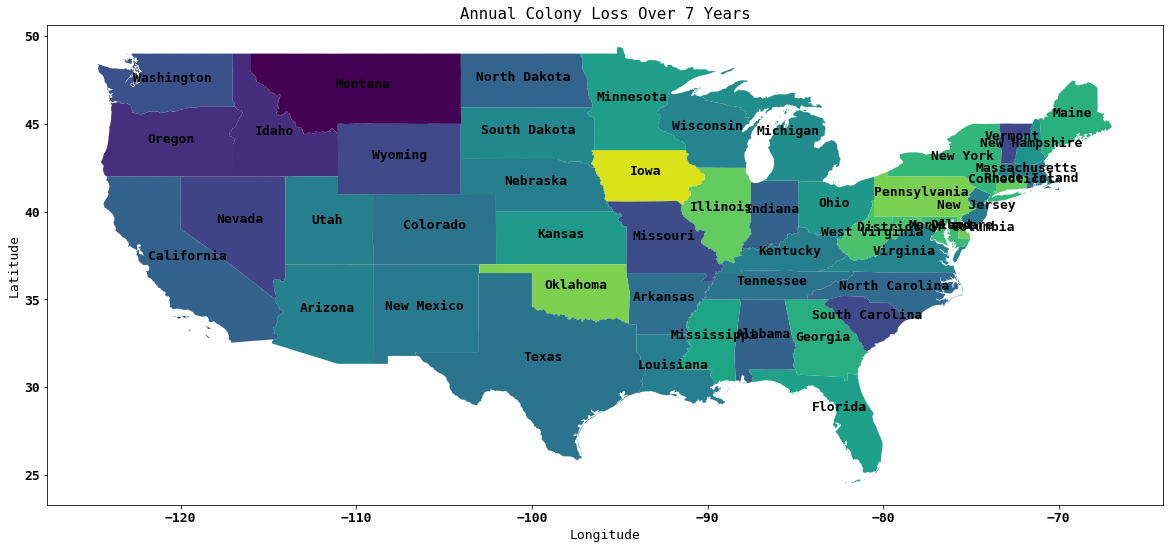

In [16]:
fig, ax = plt.subplots(1, figsize=(20,10))
c48.plot(ax=ax, column='TotalAnnualLoss', cmap='viridis', alpha=1);
plt.title("Annual Colony Loss Over 7 Years")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
for idx, row in c48.iterrows():
    plt.annotate(s=row.NAME, xy=tuple(row.centroid.coords)[0], horizontalalignment='center')

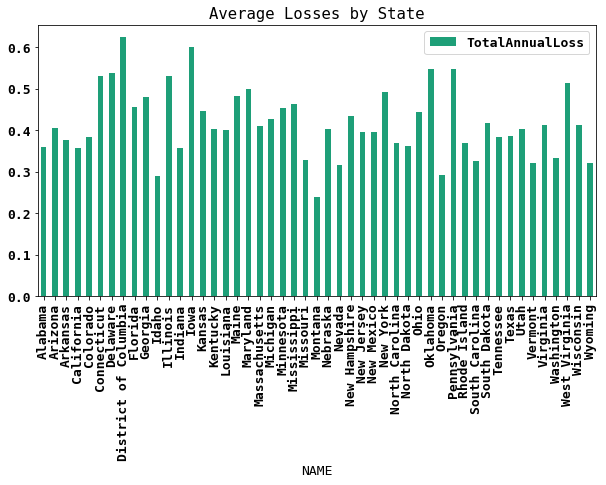

In [17]:
temp_df = c48.reset_index()
bar_setup = temp_df.drop(['GEO_ID', 'STATE', 'Beekeepers', 'Colonies'], axis=1)

bar_setup[['NAME', 'TotalAnnualLoss']].plot(x = 'NAME', y = 'TotalAnnualLoss', 
                                            color = (0.117, 0.623, 0.470),
                                            kind='bar', title='Average Losses by State');

## Do low beekeeper numbers relative to bee colonies contribute to colony loss? 

Dividing total colony count by the number of beekeepers for each state to get the number of bee colonies per beekeeper. Column names were changed in order to easily differentiate between columns.

### Re-Organising the Data

In [18]:
ColoniesPerBeekeeper = c48[['Colonies']].div(c48.Beekeepers, axis=0).round(decimals=3)
c48_divided = pd.merge(c48, ColoniesPerBeekeeper, how='outer', on='GEO_ID')

c48_divided.columns = [x.replace('Colonies_x', 'Colonies') for x in c48_divided.columns]
c48_divided.columns = [x.replace('Colonies_y', 'ColoniesPerBeekeeper') for x in c48_divided.columns]

In [19]:
c48_divided.sort_values(['ColoniesPerBeekeeper'], ascending=False, inplace=True)
c48_divided.head(5)

,STATE,NAME,geometry,TotalAnnualLoss,Beekeepers,Colonies,centroid,ColoniesPerBeekeeper
GEO_ID,,,,,,,,
0400000US38,38,North Dakota,"POLYGON ((-98.72437499999999 45.938686, -98.90...",0.361,22.286,184978.714,POINT (-100.4693145518327 47.4463360194692),8300.220
0400000US46,46,South Dakota,"POLYGON ((-104.054487 44.180381, -104.055389 4...",0.418,11.000,74748.500,POINT (-100.2304894509275 44.43615201927111),6795.318
0400000US31,31,Nebraska,"POLYGON ((-104.053249 41.001406, -104.053158 4...",0.403,11.571,54358.000,POINT (-99.81080404075655 41.52714563993714),4697.779
0400000US28,28,Mississippi,"(POLYGON ((-89.095623 30.231767, -89.077259 30...",0.463,14.667,63856.167,POINT (-89.66511602166713 32.75043647817311),4353.731
0400000US16,16,Idaho,"POLYGON ((-111.044156 43.020052, -111.044129 4...",0.289,31.857,76720.286,POINT (-114.6593261430155 44.38912386399374),2408.271


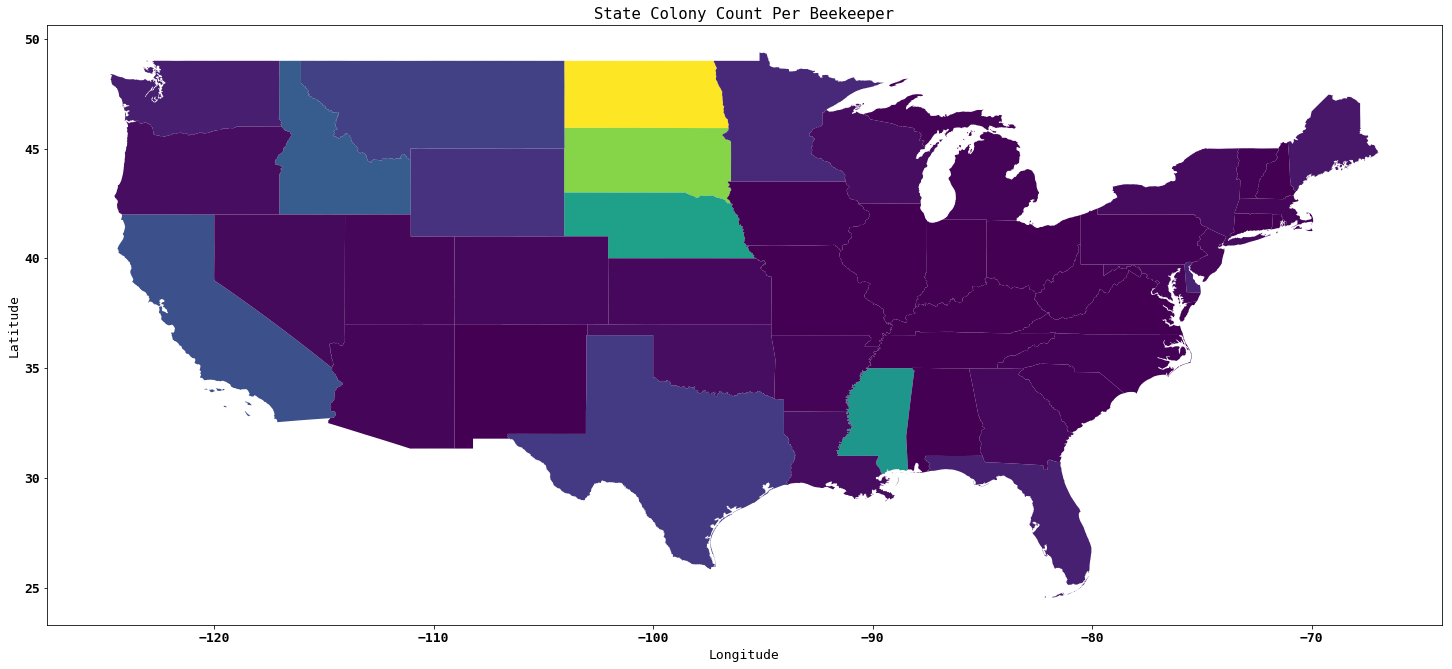

In [20]:
fig, ax = plt.subplots(1, figsize=(20,10))
c48_divided.plot(ax=ax, column='ColoniesPerBeekeeper', cmap='viridis', alpha=1);
plt.title("State Colony Count Per Beekeeper");
plt.xlabel("Longitude");
plt.ylabel("Latitude");

## What other factors might effect bee death counts?
### A new dataset is needed!

### The New Dataset

In [21]:
health_data = pd.read_csv('bee_data.csv')
health_data.sample(5)

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
9,041_058.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2201,046_134.png,8/19/18,15:46,"Des Moines, IA, USA",50315,Carniolan honey bee,healthy,False,worker
3950,032_405.png,8/21/18,9:00,"Des Moines, IA, USA",50315,Russian honey bee,healthy,False,worker
4679,019_1144.png,8/6/18,19:19,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker
3099,018_046.png,8/6/18,11:25,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker


Removing Unnecessary Data

In [22]:
health_data = health_data.drop(['file', 'date', 'time', 'zip code', 'pollen_carrying', 'caste'], axis=1)
health_data.columns = [x.replace('location', 'NAME') for x in health_data.columns]

In [23]:
health_data = health_data.replace(to_replace =
                                  ["Athens, GA, USA", "Athens, Georgia, USA"],
                                  value ="Georgia")
health_data = health_data.replace(to_replace =
                                  ["Saratoga, CA, USA"],
                                  value ="California")
health_data = health_data.replace(to_replace =
                                  ["Alvin, TX, USA"],
                                  value ="Texas")
health_data = health_data.replace(to_replace =
                                  ["Des Moines, IA, USA"],
                                  value ="Iowa")
health_data = health_data.replace(to_replace =
                                  ["New Orleans, LA, USA"],
                                  value ="Louisiana")
health_data = health_data.replace(to_replace =
                                  ["San Jose, CA, USA"],
                                  value ="California")
health_data = health_data.replace(to_replace =
                                  ["Keene, NH, USA"],
                                  value ="New Hampshire")
health_data = health_data.replace(to_replace =
                                  ["few varrao, hive beetles"],
                                  value ="Varroa, Small Hive Beetles")
health_data = health_data.replace(to_replace =
                                  ["-1"],
                                  value ="Unknown bee type")

### Grouping Data by Health and State Name

In [24]:
health_data['counts_health'] = health_data.groupby(['NAME', 'health'])['NAME'].transform('count')
health_data.sort_values("NAME", inplace = True)
health_data.drop_duplicates(keep = 'first', inplace = True)
health_data.head(12)

,NAME,subspecies,health,counts_health
2585,California,Italian honey bee,healthy,2149
5170,California,Unknown bee type,healthy,2149
4417,Georgia,1 Mixed local stock 2,"Varroa, Small Hive Beetles",1051
514,Georgia,Italian honey bee,"Varroa, Small Hive Beetles",1051
4076,Iowa,Russian honey bee,healthy,973
2979,Iowa,Carniolan honey bee,healthy,973
5146,Iowa,Western honey bee,healthy,973
665,Louisiana,VSH Italian honey bee,healthy,170
1953,New Hampshire,Russian honey bee,healthy,92
9,Texas,Unknown bee type,hive being robbed,251


### Merging the Data for Geographical Plotting

The counts_health counted the amount of times the same "NAME" and "health" specification occurred.
This gets rid of all the multiples that were created when doing this and merges it into the country GeoJson.

In [25]:
health_data.drop_duplicates(subset = ['counts_health'], keep = 'first', inplace = True)
health_data.set_index("NAME")
country_health = pd.merge(country, health_data, how='outer', on='NAME')
country_health.sample(5)

,GEO_ID,STATE,NAME,geometry,subspecies,health,counts_health
40,0400000US45,45,South Carolina,"POLYGON ((-79.29075400000001 33.110051, -79.29...",NaN,NaN,NaN
21,0400000US25,25,Massachusetts,"(POLYGON ((-70.827398 41.602067, -70.823735 41...",NaN,NaN,NaN
14,0400000US18,18,Indiana,"POLYGON ((-84.802483 40.528046, -84.802547 40....",NaN,NaN,NaN
41,0400000US46,46,South Dakota,"POLYGON ((-104.054487 44.180381, -104.055389 4...",NaN,NaN,NaN
6,0400000US09,09,Connecticut,"POLYGON ((-71.79924200000001 42.008065, -71.79...",NaN,NaN,NaN


### Finding Centroids for Geographic Plotting

The 'ishere' column is to give a boolean value of whether the state exists within the health dataset, thereby giving geographical locations for recorded areas.

In [26]:
def state_centroid(row):
    return row.geometry.centroid

country_health["centroid"] = country_health.apply(state_centroid, axis=1)
country_health["ishere"] = np.where(country_health.subspecies.isnull(), 0, 1)
country_health = country_health[country_health['NAME'].isin(['Alaska','Hawaii', 'Puerto Rico']) == False]

country_health.dropna - removes all rows with a NaN value, this is so that the state NAME labels do not include NaNs. Code condensed slightly for plot visibility.

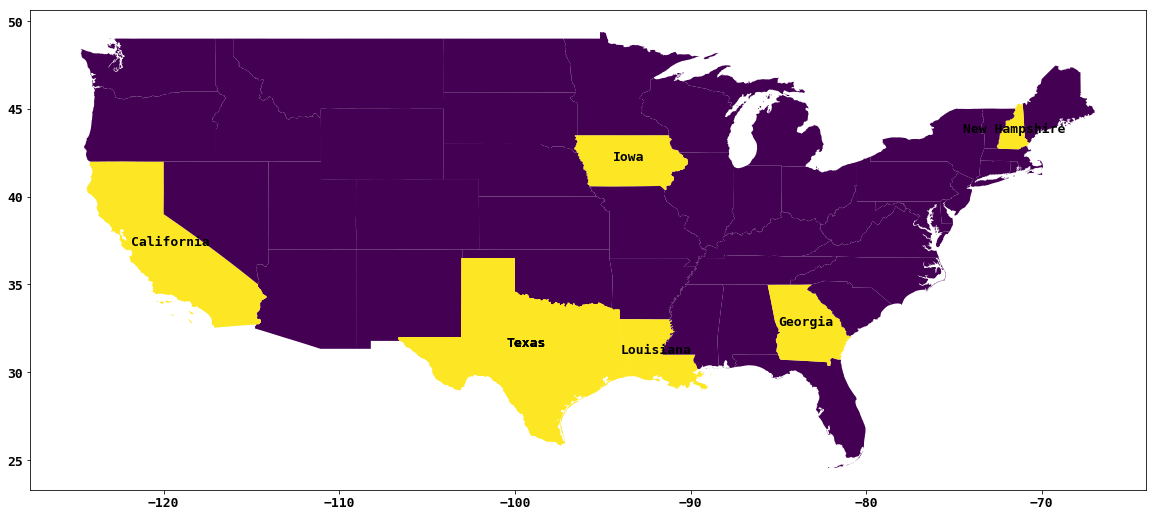

In [27]:
fig, ax = plt.subplots(1, figsize=(20,10))
country_health.plot(ax=ax, column='ishere', cmap='viridis', alpha=1);
country_health.dropna(how='any',axis='index', inplace=True)
for idx, row in country_health.iterrows():
    plt.annotate(s=row.NAME, xy=tuple(row.centroid.coords)[0],horizontalalignment='center')

Bringing 'Annual Colony Loss Over 7 Years Back', explaining why Iowa is an issue.

In [28]:
c48 = country_loss[country_loss['NAME'].isin(['Alaska','Hawaii', 'Puerto Rico']) == False] # Bye, bye, Puerto Rico!
c48 = c48.set_index("GEO_ID")

c48["centroid"] = c48.apply(state_centroid, axis=1)

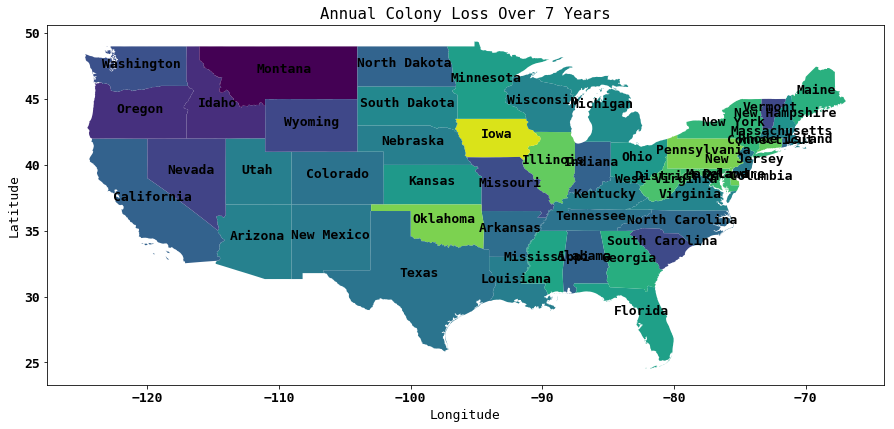

In [29]:
fig, ax = plt.subplots(1, figsize=(20,10))
c48.plot(ax=ax, column='TotalAnnualLoss', cmap='viridis', alpha=1);
plt.title("Annual Colony Loss Over 7 Years")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
for idx, row in c48.iterrows():
    plt.annotate(s=row.NAME, xy=tuple(row.centroid.coords)[0],horizontalalignment='center')

### Why Iowa?

Iowa is farming country, there is a current international surge against neonicotinoid pesticides (lab experiments linked it to bee death). Farmers in Iowa and its neighbours have been known to use this pesticide. As of May 30 2019, which is after this data was collected, an America-wide ban on neonicotinoids has been put into effect.
It would be interesting to see the effect of this ban on Iowa, Illinois, and the farming states to the west.

### How does this impact Australia?

    - Bee survival is an international issue
    
    - While varroa mites are a not in our country,
      hive beetles are throughout Australia
    
    - Some neonicotinoids are used in Australia,
      but all have been checked by APVMA's "robust
      chemical risk assessment process"
    
    - No Australian bee population/colony dataset

APVMA = Australian Pesticides and Veterinary Medicines Authority
Quote from apvma.gov.au/node/28786

Reasons for lack of Aus bee population dataset:

    - We lack the varroa mite and have large amounts of unrestricted bushland, thereby bee colony loss is less of a problem in Australia than in other countries, for example New Zealand, Europe and America, all of which suffer from the mite.
    
    - However, because of this, we don't check bee populations and would be unable to make conclusions of the effect of farming pesticides such as neonicotinoids on wild bee colonies.

    - There are datasets revolving around the bee industry, associated licences, and expected revenue, but none on the bee population so interested parties are forced to look for offshore information.
    
    - Considering the state of the decreasing bee populations internationally, it would be beneficial to have a dataset such as this in circulation.